### 2024/05/17 齊藤先生の正解データを使って線種分類器を作成する

##### ▶ライブラリを読み込む

In [138]:
import pandas as pd
import numpy as np
import requests
import io
import math
import copy
from scipy.stats import gmean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from pipeline_functions import PipelineFunctions
pf = PipelineFunctions()
from view_functions import ViewFunctions
vf = ViewFunctions()

import umap
from sklearn.manifold import TSNE
import seaborn as sns
palette = ['#CC521D', '#4F4AD7', '#39AE3D']

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix

In [139]:
data = pd.read_pickle('../data/shape_groudtruth_data.pkl').reset_index()
del data['index']

##### ▶特徴点の抽出

In [140]:
SAMPLE_PT_CNT = 5

### 特徴点抽出方法１
# 長さで等間隔に抽出
equal_interval_x = [pf.get_sampled_coord_vector_by_length(x, y, SAMPLE_PT_CNT)[0] for x, y in zip(data['normalized_x'], data['normalized_y'])]
equal_interval_y = [pf.get_sampled_coord_vector_by_length(x, y, SAMPLE_PT_CNT)[1] for x, y in zip(data['normalized_x'], data['normalized_y'])]

equal_interval_vecx = [pf.get_sampled_coord_vector_by_length(x, y, SAMPLE_PT_CNT)[2] for x, y in zip(data['normalized_x'], data['normalized_y'])]
equal_interval_vecy = [pf.get_sampled_coord_vector_by_length(x, y, SAMPLE_PT_CNT)[3] for x, y in zip(data['normalized_x'], data['normalized_y'])]

### 特徴点抽出方法２
# 座票数が指定した数より小さい場合：線分の中点に点を埋める
# 座票数が指定した数と同じ場合：そのまま
# 座票数が指定した数より大きい場合：線分間のコサイン類似度が最も高い箇所から座標を取り除く
smaller_cossim_x = []
smaller_cossim_y = []
for i, row in data.iterrows():
    if row['pt_cnt'] < SAMPLE_PT_CNT:
        over_x, over_y = pf.get_oversampled_coord(row['normalized_x'], row['normalized_y'], SAMPLE_PT_CNT)
        smaller_cossim_x.append(over_x)
        smaller_cossim_y.append(over_y)      
    elif row['pt_cnt'] == SAMPLE_PT_CNT:
        smaller_cossim_x.append(row['normalized_x'])
        smaller_cossim_y.append(row['normalized_y'])
    else:
        down_x, down_y = pf.get_downsampled_coord_by_cossim_sequentially(row['normalized_x'], row['normalized_y'], SAMPLE_PT_CNT)
        smaller_cossim_x.append(down_x)
        smaller_cossim_y.append(down_y)
        
### 特徴点抽出方法3
# 座票数が指定した数より小さい場合：線分の中点に点を埋める
# 座票数が指定した数と同じ場合：そのまま
# 座票数が指定した数より大きい場合：座標の順番が等間隔になるように抽出する
equal_coord_intervel_x = []
equal_coord_intervel_y = []
for i, row in data.iterrows():
    if row['pt_cnt'] < SAMPLE_PT_CNT:
        over_x, over_y = pf.get_oversampled_coord(row['normalized_x'], row['normalized_y'], SAMPLE_PT_CNT)
        equal_coord_intervel_x.append(over_x)
        equal_coord_intervel_y.append(over_y)      
    elif row['pt_cnt'] == SAMPLE_PT_CNT:
        equal_coord_intervel_x.append(row['normalized_x'])
        equal_coord_intervel_y.append(row['normalized_y'])
    else:
        down_x, down_y = pf.get_downsampled_coord_by_coordnum(row['normalized_x'], row['normalized_y'], SAMPLE_PT_CNT)
        equal_coord_intervel_x.append(down_x)
        equal_coord_intervel_y.append(down_y)


In [141]:
features = pd.DataFrame({
    'equal_interval_x': equal_interval_x,
    'equal_interval_y': equal_interval_y,
    'equal_interval_vecx': equal_interval_vecx,
    'equal_interval_vecy': equal_interval_vecy,
    'smaller_cossim_x': smaller_cossim_x,
    'smaller_cossim_y': smaller_cossim_y,
    'equal_coord_intervel_x': equal_coord_intervel_x,
    'equal_coord_intervel_y': equal_coord_intervel_y
})

##### ▶特徴量の導出して元データに結合

In [142]:
# 始点終点間ベクトルとのコサイン類似度を求める
# 座標間のコサイン類似度を求める
FEATURE_X = 'equal_interval_x'
FEATURE_Y = 'equal_interval_y'

startend_cossims = []
def calc_cos_sim(v1, v2):
    if (np.linalg.norm(v1) * np.linalg.norm(v2)) == 0:
        print('------------ exception -------------')
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

for xs, ys, vecxs, vecys in zip(features[FEATURE_X], features[FEATURE_Y], features['equal_interval_vecx'], features['equal_interval_vecy']):
    startend_vec = np.array([xs[-1] - xs[0], ys[-1] - ys[0]]) # 始点終点間ベクトル
    # cos_sim = [calc_cos_sim(startend_vec, np.array([x, y])) for x, y in zip(features['equal_interval_vecx'], features['equal_interval_vecy'])]
    cos_sim = [calc_cos_sim(startend_vec, np.array([vecx, vecy])) for vecx, vecy in zip(vecxs, vecys)]
    startend_cossims.append(cos_sim)

# 隣合うベクトル間のコサイン類似度を求める
next_cossims = []
for xs, ys in zip(features[FEATURE_X], features[FEATURE_Y]):
    cos_sim = [calc_cos_sim(np.array([xs[i]-xs[i-1], ys[i]-ys[i-1]]), 
                            np.array([xs[i-1]-xs[i-2], ys[i-1]-ys[i-2]])) for i in range(2, len(xs))]
    next_cossims.append(cos_sim)


In [143]:
features['startend_cossims'] = startend_cossims
features['next_cossims'] = next_cossims

In [144]:
# 元データと特徴量を削除
data_features = pd.concat([data, features], axis=1)

##### ▶「saito_label」の列が同じ割合になるように層化抽出して既存の線種判定の精度を確認する

In [145]:
# 外包矩形が3x3mm以下の線を「点」として除外する
data_rm_point = pf.remove_3x3area(data_features)
# 分類器の検証に使用するデータ
input_data = data_rm_point.copy()

# 精度のリスト
recalls = []
precisions = []
f_measures = []

K = 5
SEED = 1
LABEL = 'saito_label'
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)
for i, (train_index, test_index) in enumerate(skf.split(input_data, input_data['saito_label'])):
    # 割合の確認
    # print(f'FOLD{i}')
    # print(input_data.iloc[train_index][LABEL].value_counts(True))
    train, test = input_data.iloc[train_index], input_data.iloc[test_index]
    tp = len([ans for pred, ans in zip(test['is_good_rulebase'], test['is_good_saito']) if pred == 1 and ans == 1])
    tn = len([ans for pred, ans in zip(test['is_good_rulebase'], test['is_good_saito']) if pred == 0 and ans == 0])
    fp = len([ans for pred, ans in zip(test['is_good_rulebase'], test['is_good_saito']) if pred == 1 and ans == 0])
    fn = len([ans for pred, ans in zip(test['is_good_rulebase'], test['is_good_saito']) if pred == 0 and ans == 1])

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    f_measure = 2 * (precision * recall) / (precision + recall)
    print('TP : ', tp)
    print('TF : ', tn)
    print('FP : ', fp)
    print('FN : ', fn)
    print('recall : ', round(recall, 4))
    print('precision : ', round(precision, 4))
    print('f_measure : ', round(f_measure, 4))
    
    recalls.append(recall)
    precisions.append(precision)
    f_measures.append(f_measure)
    
print('===== 各精度の平均値 =======================================================')
print('recall: ', round(sum(recalls)/len(recalls), 4))
print('precision: ', round(sum(precisions)/len(precisions), 4))
print('F値: ', round(sum(f_measures)/len(f_measures), 4))

TP :  123
TF :  67
FP :  9
FN :  2
recall :  0.984
precision :  0.9318
f_measure :  0.9572
TP :  124
TF :  68
FP :  8
FN :  1
recall :  0.992
precision :  0.9394
f_measure :  0.965
TP :  125
TF :  68
FP :  8
FN :  0
recall :  1.0
precision :  0.9398
f_measure :  0.969
TP :  125
TF :  67
FP :  9
FN :  0
recall :  1.0
precision :  0.9328
f_measure :  0.9653
TP :  123
TF :  69
FP :  8
FN :  1
recall :  0.9919
precision :  0.9389
f_measure :  0.9647
===== 各精度の平均値 =======================================================
recall:  0.9936
precision:  0.9366
F値:  0.9642


##### ▶既存のルールベース線種判定の精度
##### ・recallの平均=0.9936
##### ・precisionの平均=0.9366
##### ・f値の平均=0.9642

##### ▶分類器の作成（上記の精度を目指す）

##### ▶訓練データのみで最大最小スケーリングする

In [147]:
###################################
INPUT_COL = 'equal_coord_intervel_y'
###################################

# 入力する特徴量を各特徴点で分ける
dict_feature_pt_col = {}
for i in range(len(features[INPUT_COL][0])):
    dict_feature_pt_col[f'feature_pt_{i}'] = [vals[i] for vals in features[INPUT_COL]]
    
input_feature = pd.DataFrame(dict_feature_pt_col)

# 最大最小でスケーリングする
INPUT_COL = 'equal_interval_vecx'
scaler = MinMaxScaler()
for col in input_feature:
    input_feature[f'normalized_{col}'] = scaler.fit_transform(input_feature[[col]])
    del input_feature[col]
    
# モデルへの入力形式に変換する
input_nparr = input_feature.to_numpy()

##### ▶▶t-SNE

finish | 2000


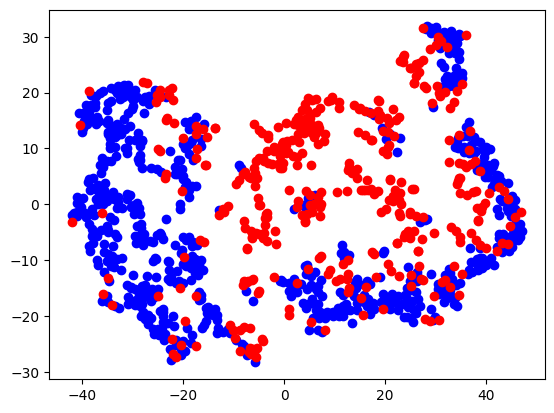

In [148]:
##### 調整可能パラメータ #####
perplexity = [ i for i in range(5, 51, 1)]
n_iter = [2000]

##### マッピング #####
for param in n_iter:
    tsne_model = TSNE(
                    n_components=2,
                    perplexity=30,
                    early_exaggeration=12.0, 
                    learning_rate='auto',
                    n_iter=param,
                    n_iter_without_progress=300,
                    min_grad_norm=1e-07,
                    metric='euclidean',
                    metric_params=None,
                    init='pca',
                    verbose=0,
                    random_state=None, 
                    method='barnes_hut',
                    angle=0.5,
                    n_jobs=None
                    )

    tsne_result = tsne_model.fit_transform(input_nparr)

    data['tsne_ax0'] = tsne_result[:, 0:1]
    data['tsne_ax1'] = tsne_result[:, 1:2]

    print(f'finish | {param}')

plt.scatter(data.query('is_good_saito == 1')['tsne_ax0'], data.query('is_good_saito == 1')['tsne_ax1'], color='blue')
plt.scatter(data.query('is_good_saito == 0')['tsne_ax0'], data.query('is_good_saito == 0')['tsne_ax1'], color='red')

##### ▶▶UMAP

C:\Users\ispec\AppData\Local\Temp\ipykernel_16012\3180297066.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x='umap_ax0', y='umap_ax1', hue=data['is_good_saito'], data=data, palette=palette, alpha=0.5)


<AxesSubplot: xlabel='umap_ax0', ylabel='umap_ax1'>

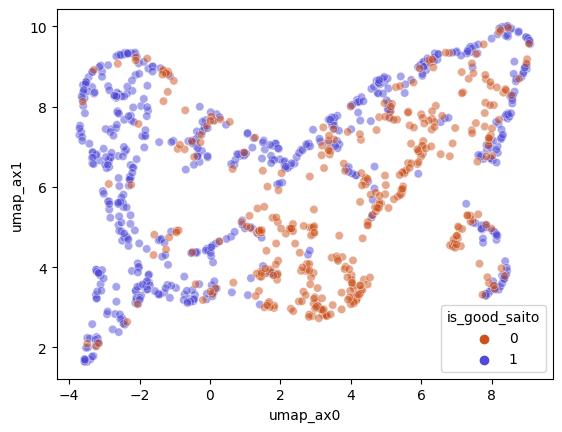

In [149]:
mapper = umap.UMAP(n_components=2, 
                n_neighbors=15,
                min_dist=0.1,
                metric = "euclidean"
                )
umap_result = mapper.fit_transform(input_nparr)

data['umap_ax0'] = umap_result[:, 0:1]
data['umap_ax1'] = umap_result[:, 1:2]

sns.scatterplot(x='umap_ax0', y='umap_ax1', hue=data['is_good_saito'], data=data, palette=palette, alpha=0.5)

##### ▶▶SVM

In [185]:
from sklearn.svm import SVC

###############################################
INPUT_COL = 'equal_interval_vecx'
K = 5
SHUFFLE_LABEL = 'saito_label'
SHUFFLE_SEED = 1
Y_COL = 'is_good_saito'
SVM_SEED = 1
###############################################

# 入力する特徴量を各特徴点で分ける
dict_feature_pt_col = {}
for i in range(len(features[INPUT_COL][0])):
    dict_feature_pt_col[f'feature_{i}'] = [vals[i] for vals in features[INPUT_COL]]
input_feature = pd.DataFrame(dict_feature_pt_col)

data_featurepts = pd.concat([data.copy(), input_feature.copy()], axis=1)

###############################################

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)
for i, (train_index, test_index) in enumerate(skf.split(data_featurepts, data_featurepts[SHUFFLE_LABEL])):
    # 訓練データとテストデータに分ける
    train, test = data_featurepts.iloc[train_index], data_featurepts.iloc[test_index]
    
    # 説明変数と目的変数に分ける
    X_COL = [col for col in data_featurepts if 'feature_' in col]
    train_X = train.copy()[X_COL]
    train_y = train.copy()[Y_COL]
    test_X = test.copy()[X_COL]
    test_y = test.copy()[Y_COL]
    
    # スケーリング
    scaler = MinMaxScaler()
    for col in train_X:
        train_X[f'norm_{col}'] = scaler.fit_transform(train[[col]])
        del train_X[col]
    
    # モデルへの入力形式に変換する
    train_X = train_X.to_numpy()
    train_y = train_y.to_numpy()
    test_X = test_X.to_numpy()
    test_y = test_y.to_numpy()
    
    # モデルに入力する
    svm_model = SVC(kernel='rbf', gamma='auto', random_state=SVM_SEED)
    svm_result = svm_model.fit(train_X, train_y)
    svm_pred = svm_model.predict(test_X)
    print(confusion_matrix(test_y, svm_pred))
    print(classification_report(test_y, svm_pred))
    
    print('##########################################')

[[51 26]
 [42 88]]
              precision    recall  f1-score   support

           0       0.55      0.66      0.60        77
           1       0.77      0.68      0.72       130

    accuracy                           0.67       207
   macro avg       0.66      0.67      0.66       207
weighted avg       0.69      0.67      0.68       207

##########################################
[[50 28]
 [37 92]]
              precision    recall  f1-score   support

           0       0.57      0.64      0.61        78
           1       0.77      0.71      0.74       129

    accuracy                           0.69       207
   macro avg       0.67      0.68      0.67       207
weighted avg       0.69      0.69      0.69       207

##########################################
[[54 24]
 [33 96]]
              precision    recall  f1-score   support

           0       0.62      0.69      0.65        78
           1       0.80      0.74      0.77       129

    accuracy                           

##### ▶▶ロジスティック回帰

In [187]:
from sklearn.linear_model import LogisticRegression

###############################################
INPUT_COL = 'startend_cossims'
K = 5
SHUFFLE_LABEL = 'saito_label'
SHUFFLE_SEED = 1
Y_COL = 'is_good_saito'
SVM_SEED = 1
###############################################

# 入力する特徴量を各特徴点で分ける
dict_feature_pt_col = {}
for i in range(len(features[INPUT_COL][0])):
    dict_feature_pt_col[f'feature_{i}'] = [vals[i] for vals in features[INPUT_COL]]
input_feature = pd.DataFrame(dict_feature_pt_col)

data_featurepts = pd.concat([data.copy(), input_feature.copy()], axis=1)

###############################################

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)
for i, (train_index, test_index) in enumerate(skf.split(data_featurepts, data_featurepts[SHUFFLE_LABEL])):
    # 訓練データとテストデータに分ける
    train, test = data_featurepts.iloc[train_index], data_featurepts.iloc[test_index]
    
    # 説明変数と目的変数に分ける
    X_COL = [col for col in data_featurepts if 'feature_' in col]
    train_X = train.copy()[X_COL]
    train_y = train.copy()[Y_COL]
    test_X = test.copy()[X_COL]
    test_y = test.copy()[Y_COL]
    
    # スケーリング
    scaler = MinMaxScaler()
    for col in train_X:
        train_X[f'norm_{col}'] = scaler.fit_transform(train[[col]])
        del train_X[col]
    
    # モデルへの入力形式に変換する
    train_X = train_X.to_numpy()
    train_y = train_y.to_numpy()
    test_X = test_X.to_numpy()
    test_y = test_y.to_numpy()
    
    # モデルに入力する
    lg_model = LogisticRegression(penalty='none')
    lg_model.fit(train_X, train_y)
    lg_pred = lg_model.predict(test_X)
    print(confusion_matrix(test_y, lg_pred))
    print(classification_report(test_y, lg_pred))

    print('##########################################')


[[ 70   7]
 [ 15 115]]
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        77
           1       0.94      0.88      0.91       130

    accuracy                           0.89       207
   macro avg       0.88      0.90      0.89       207
weighted avg       0.90      0.89      0.89       207

##########################################
[[ 69   9]
 [  8 121]]
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        78
           1       0.93      0.94      0.93       129

    accuracy                           0.92       207
   macro avg       0.91      0.91      0.91       207
weighted avg       0.92      0.92      0.92       207

##########################################
[[ 72   6]
 [ 10 119]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        78
           1       0.95      0.92      0.94       129

    accuracy               

c:\Users\ispec\MyWorkSpace\python\drawing_2024\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\ispec\MyWorkSpace\python\drawing_2024\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\ispec\MyWorkSpace\python\drawing_2024\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
c:\Users\ispec\MyWorkSpace\python\drawing_2024\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past 

##### ▶▶k-NN

In [191]:
from sklearn.neighbors import KNeighborsClassifier

###############################################
INPUT_COL = 'startend_cossims'
K = 3
SHUFFLE_LABEL = 'saito_label'
SHUFFLE_SEED = 1
Y_COL = 'is_good_saito'

###############################################

# 入力する特徴量を各特徴点で分ける
dict_feature_pt_col = {}
for i in range(len(features[INPUT_COL][0])):
    dict_feature_pt_col[f'feature_{i}'] = [vals[i] for vals in features[INPUT_COL]]
input_feature = pd.DataFrame(dict_feature_pt_col)

data_featurepts = pd.concat([data.copy(), input_feature.copy()], axis=1)

###############################################

skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=SEED)
for i, (train_index, test_index) in enumerate(skf.split(data_featurepts, data_featurepts[SHUFFLE_LABEL])):
    # 訓練データとテストデータに分ける
    train, test = data_featurepts.iloc[train_index], data_featurepts.iloc[test_index]
    
    # 説明変数と目的変数に分ける
    X_COL = [col for col in data_featurepts if 'feature_' in col]
    train_X = train.copy()[X_COL]
    train_y = train.copy()[Y_COL]
    test_X = test.copy()[X_COL]
    test_y = test.copy()[Y_COL]
    
    # スケーリング
    scaler = MinMaxScaler()
    for col in train_X:
        train_X[f'norm_{col}'] = scaler.fit_transform(train[[col]])
        del train_X[col]
    
    # モデルへの入力形式に変換する
    train_X = train_X.to_numpy()
    train_y = train_y.to_numpy()
    test_X = test_X.to_numpy()
    test_y = test_y.to_numpy()
    
    # モデルに入力する
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(train_X, train_y)
    knn_pred = knn_model.predict(test_X)
    print(confusion_matrix(test_y, knn_pred))
    print(classification_report(test_y, knn_pred))

    print('##########################################')

[[118  11]
 [ 25 191]]
              precision    recall  f1-score   support

           0       0.83      0.91      0.87       129
           1       0.95      0.88      0.91       216

    accuracy                           0.90       345
   macro avg       0.89      0.90      0.89       345
weighted avg       0.90      0.90      0.90       345

##########################################
[[122   8]
 [ 19 196]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       130
           1       0.96      0.91      0.94       215

    accuracy                           0.92       345
   macro avg       0.91      0.93      0.92       345
weighted avg       0.92      0.92      0.92       345

##########################################
[[124   6]
 [ 15 200]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92       130
           1       0.97      0.93      0.95       215

    accuracy               